<a href="https://colab.research.google.com/github/Mepha89/Machine-Learning-with-Python/blob/main/Cat_vs_Dog_Identifier/Cat_vs_Dog_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Using a Pretrained Model
In this section we will combine the tecniques we learned above and use a pretrained model and fine tuning to classify images of dogs and cats using a small dataset.

*This tutorial is based on the following guide from the TensorFlow documentation: https://www.tensorflow.org/tutorials/images/transfer_learning*




In [1]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

###Dataset
We will load the *cats_vs_dogs* dataset from the modoule tensorflow_datatsets.

This dataset contains (image, label) pairs where images have different dimensions and 3 color channels.



In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


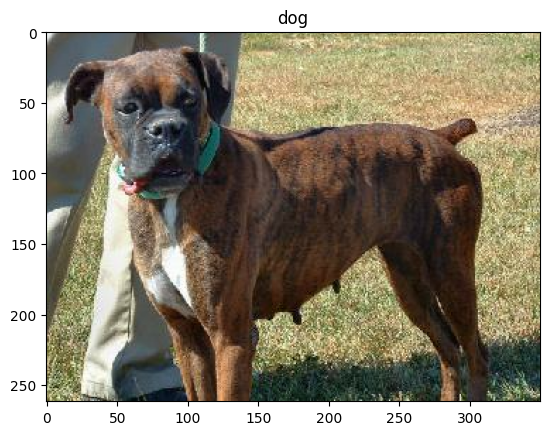

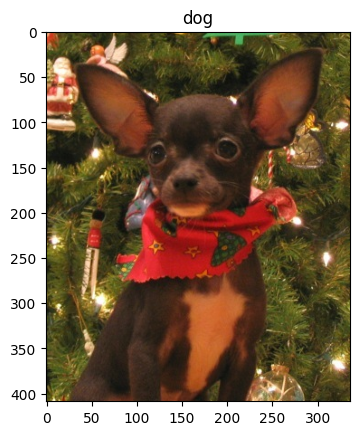

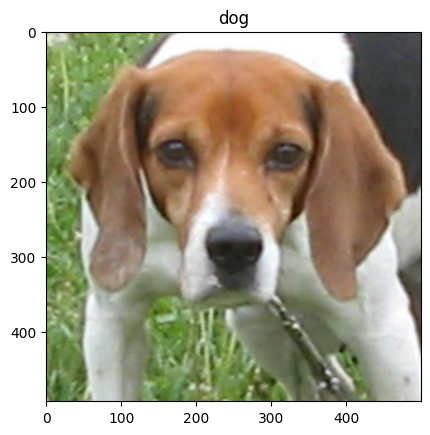

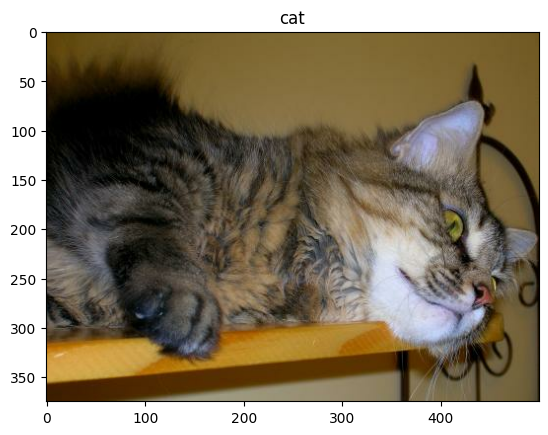

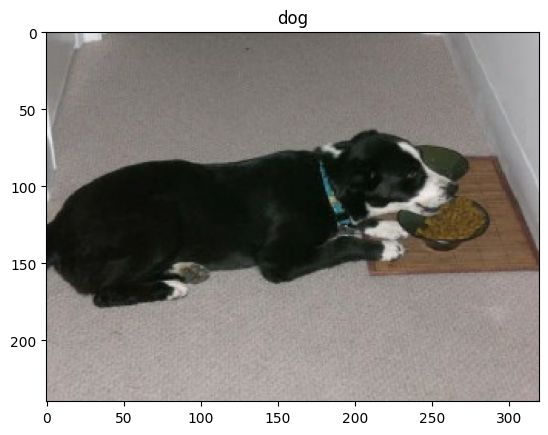

In [3]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

###Data Preprocessing
Since the sizes of our images are all different, we need to convert them all to the same size. We can create a function that will do that for us below.



In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

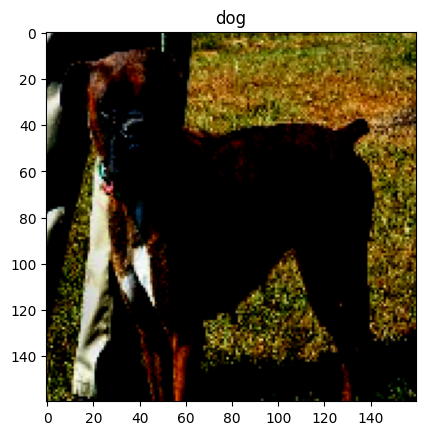

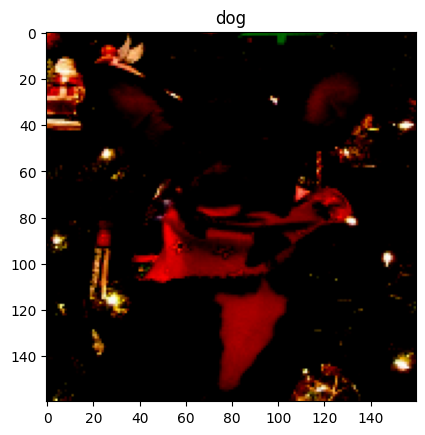

In [6]:
# we can look at the image
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [7]:
# we will shuffle and batch the images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
# original shape vs new image shape

for img, label in raw_train.take(2):
  print("Original shape:", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


###Picking a Pretrained Model
The model we are going to use as the convolutional base for our model is the **MobileNet V2** developed at Google. This model is trained on 1.4 million images and has 1000 different classes.

We want to use this model but only its convolutional base. So, when we load in the model, we'll specify that we don't want to load the top (classification) layer. We'll tell the model what input shape to expect and to use the predetermined weights from *imagenet* (Googles dataset).



In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

At this point this *base_model* will simply output a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image. The 32 means that we have 32 layers of differnt filters/features.

In [11]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


###Freezing the Base
The term **freezing** refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.



In [12]:
base_model.trainable = False

In [ ]:
base_model.summary()

###Adding our Classifier
Now that we have our base layer setup, we can add the classifier. Instead of flattening the feature map of the base layer we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1280 element vector per filter.  



In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [15]:
prediction_layer = keras.layers.Dense(1)

In [16]:
# we will combine these layers together in a model 

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


###Training the Model
Now we will train and compile the model. We will use a very small learning rate to ensure that the model does not have any major changes made to it.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 10s 401ms/step - loss: 0.6932 - accuracy: 0.5281


In [21]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 281s 480ms/step - loss: 0.0350 - accuracy: 0.9874 - val_loss: 0.0458 - val_accuracy: 0.9832
Epoch 2/3
582/582 [==============================] - 255s 437ms/step - loss: 0.0335 - accuracy: 0.9885 - val_loss: 0.0450 - val_accuracy: 0.9854
Epoch 3/3
582/582 [==============================] - 261s 447ms/step - loss: 0.0317 - accuracy: 0.9887 - val_loss: 0.0452 - val_accuracy: 0.9854
[0.9873723983764648, 0.9885008335113525, 0.9886620044708252]


In [22]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')